# Estimated marginal effect size vs MAF

In [39]:
from __future__ import annotations

import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import itertools

import pandas as pd
from scipy.stats.contingency import odds_ratio
from scipy.stats import fisher_exact
import numpy as np


In [2]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("muted"))


In [3]:
dataset_path = "../../data/binary-therapeutic-lead-variants.parquet"
dataset = pl.read_parquet(dataset_path)


In [19]:
def categorize_by_maf_effect(maf: pl.Expr, beta: pl.Expr, maf_cap: float = 0.01, beta_cap: float = 1.0) -> pl.Expr:
    """Categorize the dataset by maf and effect size.

    NOTE: One should pass absolute value of beta

    There are 4 categories:
    (1) weak effect, low MAF - WL
    (2) weak effect, high MAF - WH
    (3) strong effect, high MAF - SH
    (4) strong effect, low MAF - SL
    """
    beta = beta.abs()
    return (
        pl.when(((beta < beta_cap) & (maf < maf_cap)))
        .then(pl.lit("WL"))
        .when(((beta < beta_cap) & (maf >= maf_cap)))
        .then(pl.lit("WH"))
        .when(((beta >= beta_cap) & (maf >= maf_cap)))
        .then(pl.lit("SH"))
        .when(((beta >= beta_cap) & (maf < maf_cap)))
        .then(pl.lit("SL"))
        .alias("effectMAFCategory")
    )


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


def convert_name(name: str):
    """Convert name of maf_effect category to label."""
    assert len(name) == 2
    match name:
        case "WL":
            return "Weak Effect, Low Frequency"
        case "WH":
            return "Weak Effect, High Frequency"
        case "SH":
            return "Strong Effect, High Frequency"
        case "SL":
            return "Strong Effect, Low Frequency"


class OddsRatioGenerator:
    class OddsRatio:
        """Object for odds ratio."""

        def __init__(
            self, ct: pd.DataFrame, group1: str, group2: str, exp1: str, exp2: str, a: int, b: int, c: int, d: int
        ):
            assert ct.shape == (2, 2)
            self.ci_level = 0.95
            self.group1 = group1
            self.group2 = group2
            self.exp1 = exp1
            self.exp2 = exp2
            self.ct = ct
            self.odds_ratio = None
            self.ci = None
            self.fisher_odds = None
            self.fisher_pval = None
            self.a = a
            self.b = b
            self.c = c
            self.d = d

        def calculate(
            self,
        ) -> None:
            """Calculate odds ratio and ci."""
            if not self.odds_ratio:
                self.odds_ratio = odds_ratio(self.ct)
                self.ci = self.odds_ratio.confidence_interval(self.ci_level)
                self.fisher_odds, self.fisher_pval = fisher_exact(self.ct)

        def __repr__(self) -> str:
            """Reprint the object."""
            return f"OR = {round(self.odds_ratio.statistic, 2)} ({self.ci_level}% CI:{round(self.ci.low, 2)},{round(self.ci.high, 2)})"

    def contingency_tables(self, df: pl.DataFrame, exposure_variable: pl.Expr, group_variable: pl.Expr) -> None:
        """Split the multigroup dataset into 2x2 contingency tables."""
        exp_alias = "exposure"
        grp_alias = "group"
        groups = df.select(group_variable.alias(grp_alias))[grp_alias].unique()
        exposures = df.select(exposure_variable.alias(exp_alias))[exp_alias].unique()
        ors: list[OddsRatioGenerator.OddsRatio] = []
        for group1, group2 in itertools.combinations(groups, 2):
            for idx, exposure1 in enumerate(exposures):
                ct1 = df.filter(group_variable == group1)
                ct2 = df.filter(group_variable == group2)
                a = ct1.filter(exposure_variable == exposure1).shape[0]
                b = ct1.filter(exposure_variable != exposure1).shape[0]
                c = ct2.filter(exposure_variable == exposure1).shape[0]
                d = ct2.filter(exposure_variable != exposure1).shape[0]
                exposure2 = f"non {exposure1}"
                _ct = pd.DataFrame([(group1, a, b), (group2, c, d)], columns=["group", exposure1, exposure2]).set_index(
                    "group"
                )
                _or = self.OddsRatio(_ct, group1, group2, exposure1, exposure2, a, b, c, d)
                _or.calculate()
                ors.append(_or)
        return pd.DataFrame(
            [
                (
                    f"{stats.group1} / {stats.group2} / {stats.exp1}",
                    f"{str(stats)}",
                    stats.group1,
                    stats.group2,
                    stats.exp1,
                    stats.exp2,
                    round(stats.odds_ratio.statistic, 2),
                    round(stats.ci.low, 2),
                    round(stats.ci.high, 2),
                    stats.ci_level,
                    stats.a,
                    stats.b,
                    stats.c,
                    stats.d,
                    stats.fisher_pval,
                    stats.fisher_odds,
                )
                for stats in ors
            ],
            columns=[
                "condition",
                "report",
                "group1",
                "group2",
                "exp1",
                "exp2",
                "oddsRatio",
                "CILow",
                "CIHigh",
                "CILevel",
                "nGroup1Exp1",
                "nGroup1Exp2",
                "nGroup2Exp1",
                "nGroup2Exp2",
                "fisherPval",
                "fisherOdds",
            ],
        )


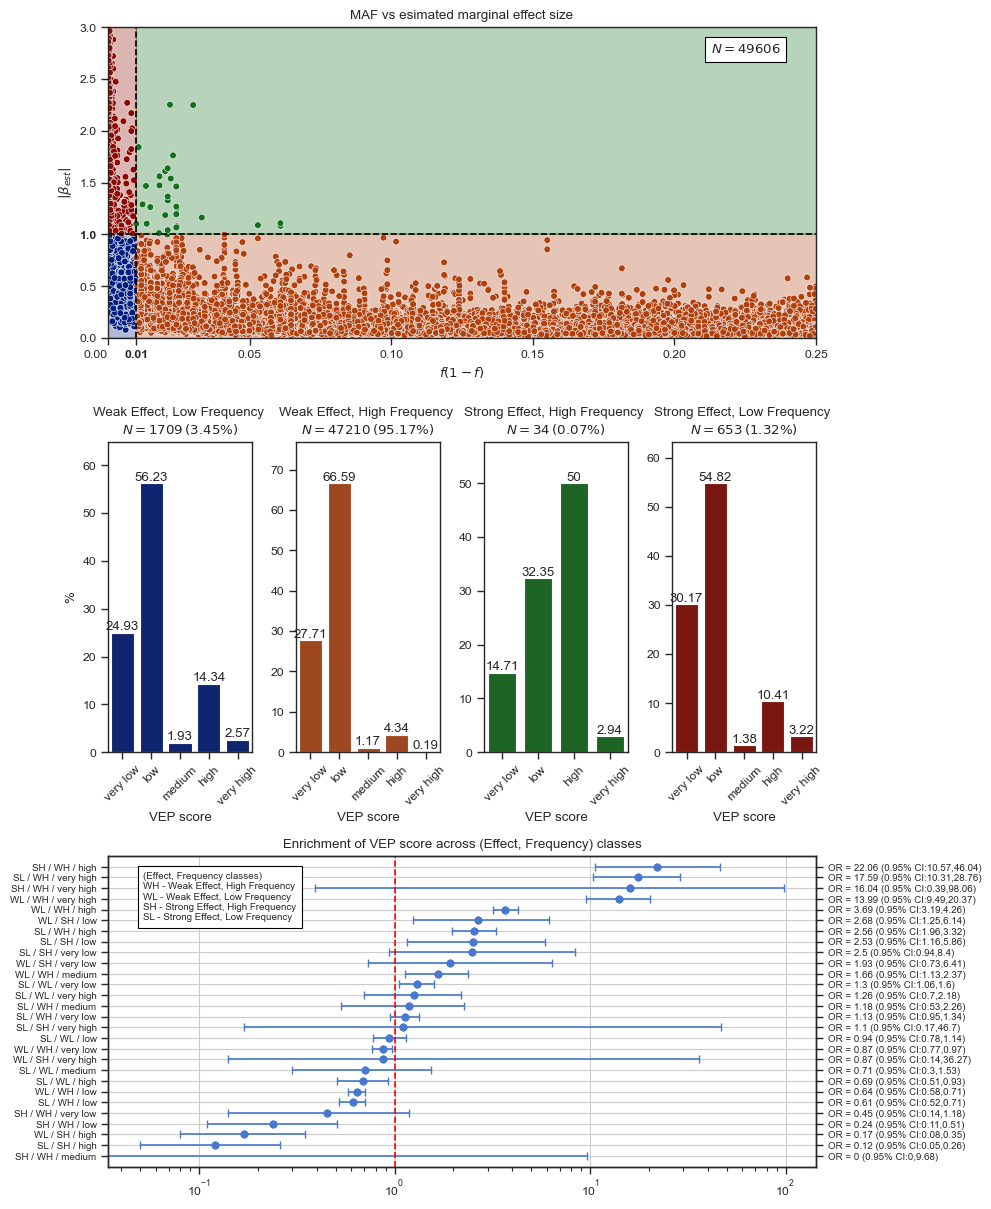

In [143]:
base_palette = sns.color_palette("dark")
transparent_palette = [mcolors.to_rgba(color, alpha=0.3) for color in base_palette]
maf_cap = 0.01
beta_cap = 1.0
# rect_alpha = 1.0
data = dataset.select(
    pl.col("rescaledStatistics").struct.field("estimatedBeta").abs().alias("absEstimatedBeta"),
    pl.col("rescaledStatistics").struct.field("estimatedBeta").pow(2).alias("EstimatedBeta"),
    pl.col("majorPopulationMAF"),
    ((pl.lit(1) - pl.col("majorPopulationMAF")) * pl.col("majorPopulationMAF")).alias("expectedVarianceOfBiallelicSNP"),
    categorize_by_maf_effect(pl.col("majorPopulationMAF"), pl.col("rescaledStatistics").struct.field("estimatedBeta")),
    pl.col("vepEffect").struct.field("assessment"),
    pl.col("vepEffect").struct.field("normalisedScore"),
    classify_by_vep_score(pl.col("vepEffect")),
)
maf_min = data["expectedVarianceOfBiallelicSNP"].min()
beta_min = data["absEstimatedBeta"].min()
maf_max = data["expectedVarianceOfBiallelicSNP"].max()
beta_max = data["absEstimatedBeta"].max()
groups: dict[str, dict] = {
    "WL": {"xy": (maf_min, beta_min), "width": maf_cap, "height": beta_cap, "color": transparent_palette[0]},
    "WH": {"xy": (maf_cap, beta_min), "width": maf_max, "height": beta_cap, "color": transparent_palette[1]},
    "SH": {"xy": (maf_cap, beta_cap), "width": maf_max, "height": beta_max, "color": transparent_palette[2]},
    "SL": {"xy": (maf_min, beta_cap), "width": maf_cap, "height": beta_max, "color": transparent_palette[3]},
}
fig = plt.figure(figsize=(10, 16))
ax1 = fig.add_subplot(4, 2, (1, 2))
sns.scatterplot(
    data=data,
    x="expectedVarianceOfBiallelicSNP",
    y="absEstimatedBeta",
    ax=ax1,
    hue="effectMAFCategory",
    hue_order=["WL", "WH", "SH", "SL"],
    palette=base_palette[0:4],
)
counts = (
    data.group_by("effectMAFCategory")
    .agg(pl.len())
    .select(
        "effectMAFCategory",
        "len",
        ((pl.col("len") / pl.col("len").sum()) * pl.lit(100)).round(2).alias("%"),
    )
)
ax1.set_ylabel(r"$\vert\beta_{est}\vert$")
ax1.set_xlabel(r"$f(1-f)$")
ax1.set_title("MAF vs esimated marginal effect size")
ax1.axvline(x=maf_cap, color="black", linestyle="--")
ax1.axhline(y=beta_cap, color="black", linestyle="--")
ax1.set_ylim(ymin=0, ymax=beta_max)
ax1.set_xlim(xmin=0, xmax=maf_max)
x_ticks = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
y_ticks = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
x_ticklabels = ax1.get_xticklabels()
for label in x_ticklabels:
    if label.get_text() == "0.00":
        label.set_horizontalalignment("right")
    if label.get_text() == str(maf_cap):
        label.set_fontweight(1000)
y_ticklabels = ax1.get_yticklabels()
for label in y_ticklabels:
    if label.get_text() == str(beta_cap):
        label.set_fontweight(1000)


point_counts = {name: counts.filter(pl.col("effectMAFCategory") == name)["len"].first() for name in groups}
point_percent = {name: counts.filter(pl.col("effectMAFCategory") == name)["%"].first() for name in groups}
for name, specs in groups.items():
    ax1.add_patch(Rectangle(**specs, fill=True, zorder=-10))

handles, labels = ax1.get_legend_handles_labels()
colors = []
for h in handles:
    if isinstance(h, Rectangle):
        colors.append(h.get_facecolor())
new_labels = [f"{convert_name(name)} \n$N={point_counts[name]}\,({point_percent[name]}\%)$" for name in labels]
ax1.text(
    x=0.95,
    y=0.95,
    s=f"$N={data.shape[0]}$",
    transform=ax1.transAxes,
    ha="right",
    va="top",
    bbox=dict(facecolor="white", edgecolor="black"),
)

ax1.legend().set_visible(False)


for idx, grp in enumerate(labels):
    # Plot the functional breakdown for each of 4 groups
    _data = (
        data.filter(pl.col("effectMAFCategory") == grp)
        .group_by("effectMAFCategory", "vepScoreClass")
        .agg(pl.len().alias("count"), pl.col("normalisedScore").first().alias("order"))
        .select(
            pl.col("effectMAFCategory"),
            pl.col("vepScoreClass"),
            pl.col("count"),
            ((pl.col("count") / pl.col("count").sum()) * pl.lit(100)).round(2).alias("%"),
            pl.col("order"),
        )
        .sort("order")
    )
    ax2 = fig.add_subplot(4, 4, 5 + idx)
    bar = sns.barplot(
        data=_data,
        x="vepScoreClass",
        y="%",
        ax=ax2,
        estimator="sum",
        hue="effectMAFCategory",
        palette=transparent_palette[0 + idx : 1 + idx],
        legend=None,
    )
    _, labels = ax2.get_legend_handles_labels()
    x_ticklabels = ax2.get_xticklabels()
    for label in x_ticklabels:
        label.set_rotation(45)
    ax2.set_title(new_labels[idx])
    ax2.bar_label(bar.containers[0])
    ylim_top = ax2.get_ylim()[1]
    new_ylim = ylim_top + ylim_top * 0.1
    ax2.set_ylim(0, new_ylim)
    yticks = ax2.get_yticklabels()
    ax2.set_xlabel("VEP score")
    ax2.set_ylabel("%")
    if idx > 0:
        ax2.set_ylabel("")

# ax_legend = fig.add_subplot(4, 2, 2)
# ax_legend.legend(handles=handles, labels=new_labels, loc="center")  # Place legend in next subplot
# ax_legend.axis("off")
ax3 = fig.add_subplot(4, 2, (5, 6))
vep_scores = ["very low", "low", "medium", "high", "very high"]


ors = (
    OddsRatioGenerator()
    .contingency_tables(df=data, exposure_variable=pl.col("vepScoreClass"), group_variable=pl.col("effectMAFCategory"))
    .replace(np.inf, np.nan)
    .replace(-np.inf, np.nan)
    .dropna()
    .sort_values(by=["oddsRatio"])
    .reset_index(drop=True)
)
y_ticks = list(range(len(ors["oddsRatio"])))
ax3.scatter(x=ors["oddsRatio"], y=y_ticks)
ax3.errorbar(
    x=ors["oddsRatio"],
    y=y_ticks,
    xerr=[ors["oddsRatio"] - ors["CILow"], ors["CIHigh"] - ors["oddsRatio"]],
    fmt="o",
    capsize=3,
    label="Point estimate ± CI",
)
ax4 = ax3.twinx()

ax3.set_yticks(y_ticks)
ax3.set_yticklabels(
    ors["condition"],
    fontdict=dict(fontsize=7),
)
ax4.set_yticks(y_ticks)
ax4.set_yticklabels(
    ors["report"],
    fontdict=dict(fontsize=7),
)
ax3.set_ylim(-1, len(y_ticks))
ax4.set_ylim(-1, len(y_ticks))
ax3.grid()

ax4.text(
    x=0.05,
    y=0.95,
    s="(Effect, Frequency classes)\nWH - Weak Effect, High Frequency\nWL - Weak Effect, Low Frequency\nSH - Strong Effect, High Frequency\nSL - Strong Effect, Low Frequency",
    transform=ax4.transAxes,
    ha="left",
    va="top",
    bbox=dict(facecolor="white", edgecolor="black"),
    fontdict=dict(fontsize=7),
)
ax4.axvline(x=1, color="red", linestyle="--")
ax3.set_xscale("log")
ax3.set_title("Enrichment of VEP score across (Effect, Frequency) classes")
fig.tight_layout()


In [119]:
ors.sort_index(ascending=False)


,condition,report,group1,group2,exp1,exp2,oddsRatio,CILow,CIHigh,CILevel,nGroup1Exp1,nGroup1Exp2,nGroup2Exp1,nGroup2Exp2,fisherPval,fisherOdds
27,SH / WL / high,"OR = 5.97 (0.95% CI:2.82,12.62)",SH,WL,high,non high,5.97,2.82,12.62,0.95,17,17,245,1464,1.311757e-06,5.975510
26,WH / SH / low,"OR = 4.17 (0.95% CI:1.95,9.47)",WH,SH,low,non low,4.17,1.95,9.47,0.95,31438,15772,11,23,6.490944e-05,4.167766
25,SL / SH / low,"OR = 2.53 (0.95% CI:1.16,5.86)",SL,SH,low,non low,2.53,1.16,5.86,0.95,358,295,11,23,1.288063e-02,2.537442
24,SL / SH / very low,"OR = 2.5 (0.95% CI:0.94,8.4)",SL,SH,very low,non very low,2.50,0.94,8.40,0.95,197,456,5,29,5.517114e-02,2.505702
23,WH / SH / very low,"OR = 2.22 (0.95% CI:0.85,7.36)",WH,SH,very low,non very low,2.22,0.85,7.36,0.95,13082,34128,5,29,1.230834e-01,2.223265
22,WH / SL / low,"OR = 1.64 (0.95% CI:1.4,1.92)",WH,SL,low,non low,1.64,1.40,1.92,0.95,31438,15772,358,295,7.086114e-10,1.642507
21,WH / WL / low,"OR = 1.55 (0.95% CI:1.41,1.71)",WH,WL,low,non low,1.55,1.41,1.71,0.95,31438,15772,961,748,2.620675e-18,1.551481
20,SL / WL / very low,"OR = 1.3 (0.95% CI:1.06,1.6)",SL,WL,very low,non very low,1.30,1.06,1.60,0.95,197,456,426,1283,1.053441e-02,1.301123
19,SL / WL / very high,"OR = 1.26 (0.95% CI:0.7,2.18)",SL,WL,very high,non very high,1.26,0.70,2.18,0.95,21,632,44,1665,4.001589e-01,1.257372
18,WH / WL / very low,"OR = 1.15 (0.95% CI:1.03,1.29)",WH,WL,very low,non very low,1.15,1.03,1.29,0.95,13082,34128,426,1283,1.128031e-02,1.154464
